In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud

import torch
import time 
import random
import numpy as np
import re
import string
import nltk
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from transformers import MarianMTModel, MarianTokenizer
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Input, Dropout, Embedding
from tensorflow.keras import Model
from tensorflow.keras.initializers import Constant

import warnings
warnings.filterwarnings("ignore")

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset: https://www.kaggle.com/datasets/nelgiriyewithana/emotions/code

In [2]:
data = pd.read_csv('data/text.csv', index_col=0)
data.head()

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


The emotions are classified into six categories: sadness (0), joy (1), love (2), anger (3), fear (4), and surprise (5).

### Data description, visualization and statistical analysis

In [3]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 416809 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    416809 non-null  object
 1   label   416809 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 9.5+ MB
None


In [4]:
missing_values = data.isnull().sum()
print(f"Missing values:\n{missing_values}")

duplicate_entries = data.duplicated().sum()
print(f"Duplicate entries: {duplicate_entries}")

Missing values:
text     0
label    0
dtype: int64
Duplicate entries: 686


In [5]:
for i in range(min(5, len(data))):
    print(data['text'].iloc[i], "\n")

i just feel really helpless and heavy hearted 

ive enjoyed being able to slouch about relax and unwind and frankly needed it after those last few weeks around the end of uni and the expo i have lately started to find myself feeling a bit listless which is never really a good thing 

i gave up my internship with the dmrg and am feeling distraught 

i dont know i feel so lost 

i am a kindergarten teacher and i am thoroughly weary of my job after having taken the university entrance exam i suffered from anxiety for weeks as i did not want to carry on with my work studies were the only alternative 



In [6]:
data = data.drop_duplicates()

### Data sentiment

In [7]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

In [8]:
data['polarity'] = data['text'].apply(polarity)
data.head()

,text,label,polarity
0,i just feel really helpless and heavy hearted,4,0.000
1,ive enjoyed being able to slouch about relax a...,0,0.025
2,i gave up my internship with the dmrg and am f...,4,-0.600
3,i dont know i feel so lost,0,0.000
4,i am a kindergarten teacher and i am thoroughl...,4,0.000


In [9]:
def sentiment(label):
    if label <0:
        return "Negative"
    elif label ==0:
        return "Neutral"
    elif label>0:
        return "Positive"

In [10]:
data['sentiment'] = data['polarity'].apply(sentiment)
data.head()

,text,label,polarity,sentiment
0,i just feel really helpless and heavy hearted,4,0.000,Neutral
1,ive enjoyed being able to slouch about relax a...,0,0.025,Positive
2,i gave up my internship with the dmrg and am f...,4,-0.600,Negative
3,i dont know i feel so lost,0,0.000,Neutral
4,i am a kindergarten teacher and i am thoroughl...,4,0.000,Neutral


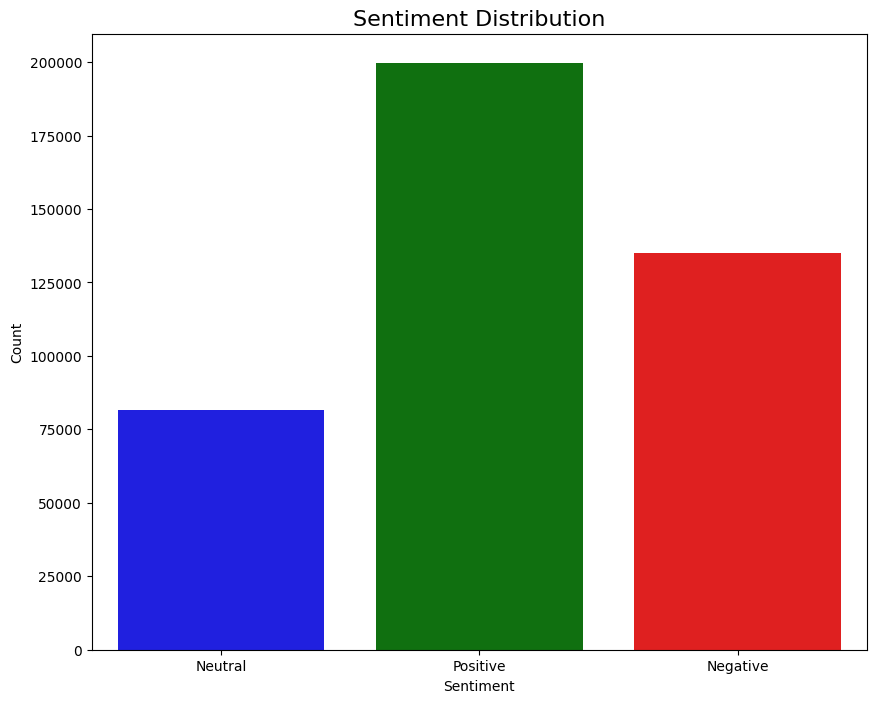

In [11]:
palette = {"Negative": "red", "Neutral": "blue", "Positive": "green"}

plt.figure(figsize=(10, 8))
sns.countplot(x='sentiment', data=data, palette=palette)
plt.title('Sentiment Distribution', fontsize=16)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

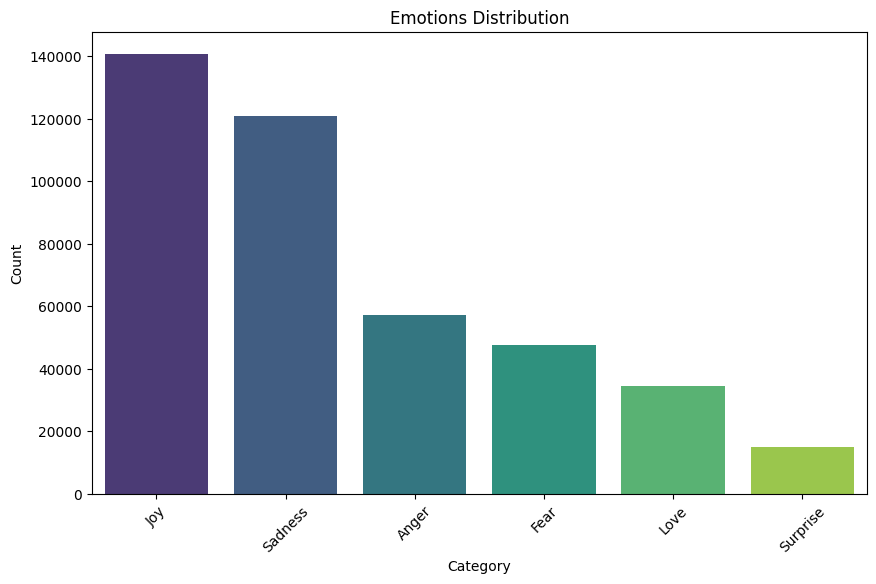

In [12]:
category_dict = {0: "Sadness", 1: "Joy", 2: "Love", 3: "Anger", 4: "Fear", 5: "Surprise"}
data["Category"] = data["label"].map(category_dict)
label_counts = data["Category"].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('Emotions Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [13]:
group_counts = data['label'].value_counts()
print(group_counts)

label
1    140779
0    120989
3     57235
4     47664
2     34497
5     14959
Name: count, dtype: int64


In [14]:
min_count = group_counts.min()
balanced_df = data.groupby('label').apply(lambda x: x.sample(min_count)).reset_index(drop=True)
print(balanced_df['label'].value_counts())

label
0    14959
1    14959
2    14959
3    14959
4    14959
5    14959
Name: count, dtype: int64


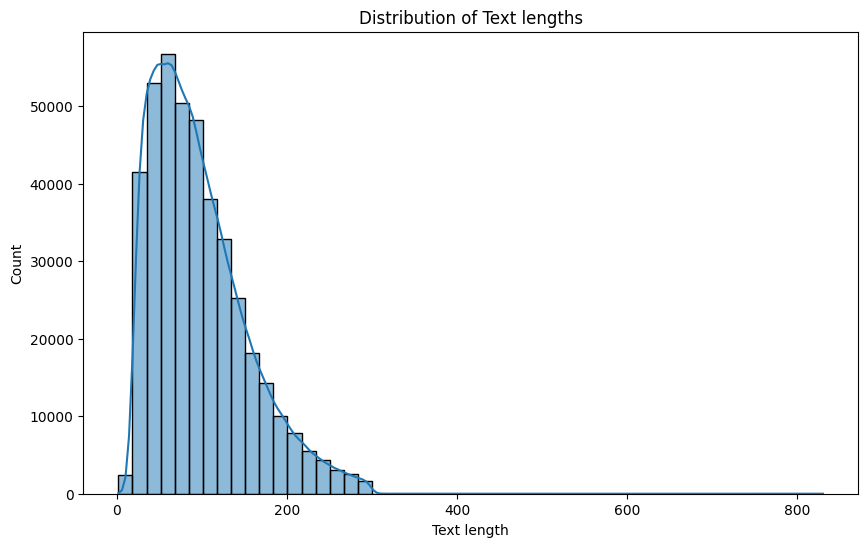

In [15]:
plt.figure(figsize=(10,6))
sns.histplot(data['text'].apply(len), bins=50, kde=True)
plt.title('Distribution of Text lengths')
plt.xlabel('Text length')
plt.ylabel('Count')
plt.show()

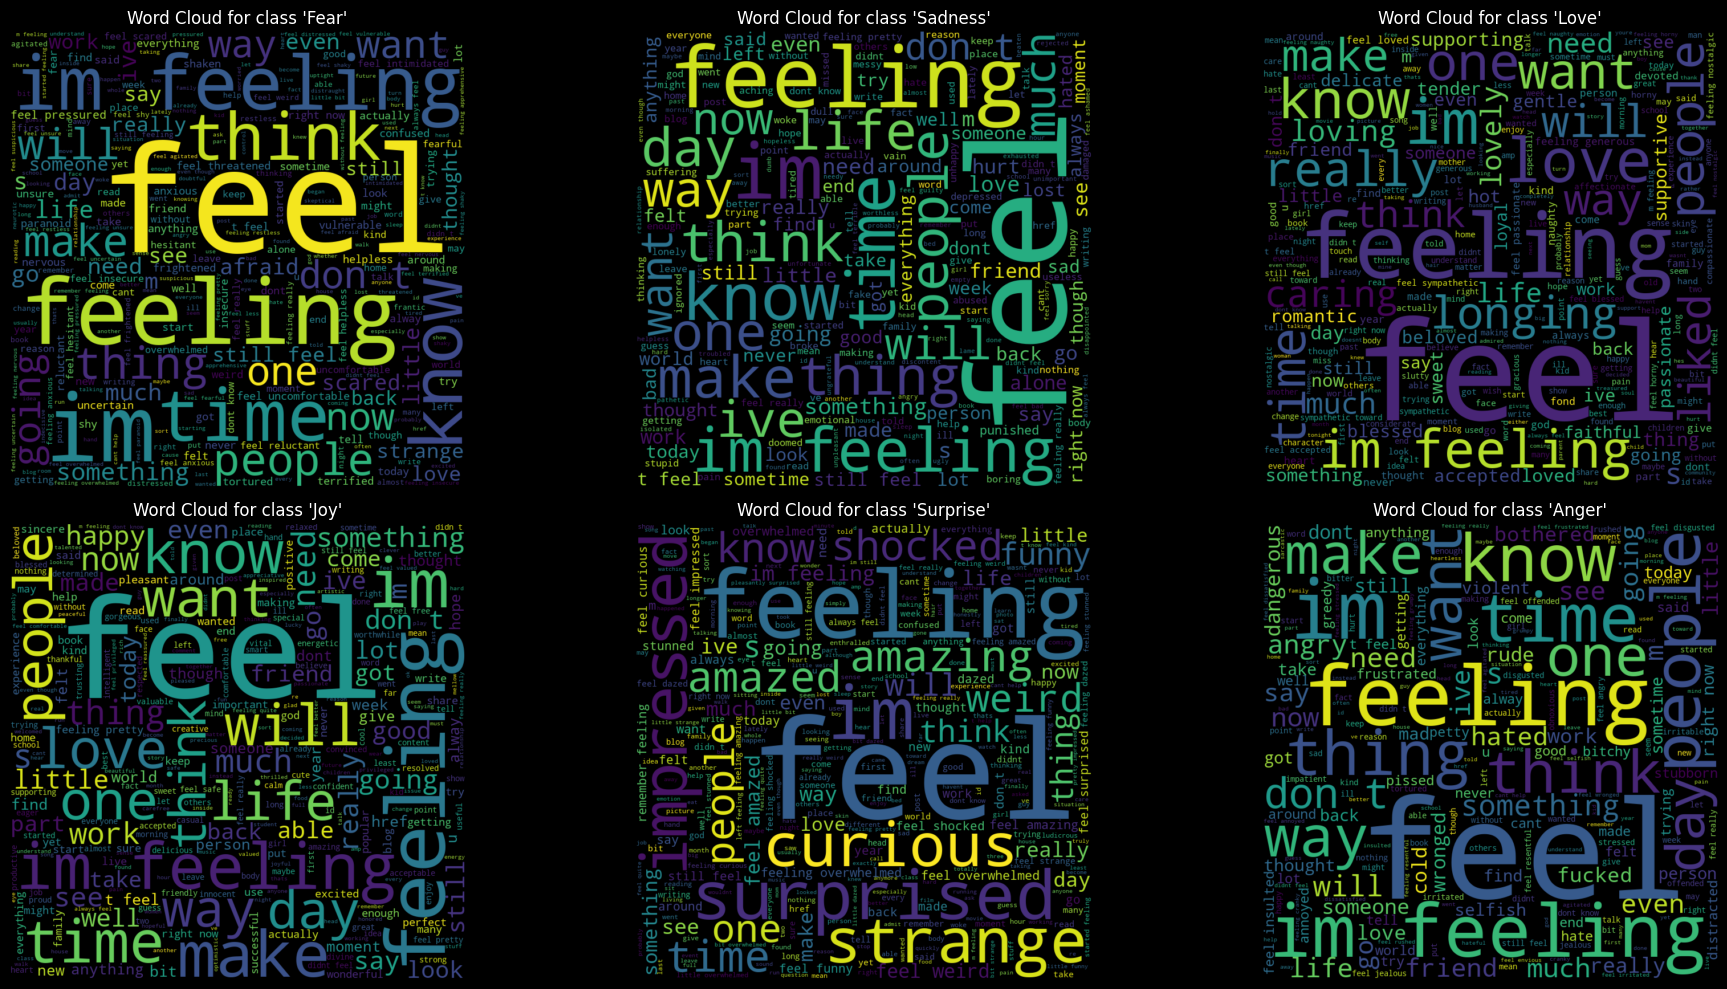

In [16]:
def generate_wordcloud(text, ax, title):
    wordcloud = WordCloud(width=800, height=800, 
                          background_color='black', 
                          stopwords=None, 
                          max_words=400,
                          min_font_size=10).generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(title, color='white')
    ax.axis("off")

fig, axs = plt.subplots(2, 3, figsize=(20, 10), facecolor='black')

for i, label in enumerate(data['label'].unique()):
    text = ' '.join(data[data['label'] == label]['text'])
    row = i // 3
    col = i % 3
    generate_wordcloud(text, axs[row, col], f"Word Cloud for class '{category_dict[label]}'")

plt.tight_layout()
plt.show()

### Data preprocessing

In [12]:
nltk.download('stopwords')
stop_words = stopwords.words('english')

def data_cleaning(text):

    # Convert to lower
    text = text.lower()
    
    remove_stopwords = [word for word in text.split() if word not in stop_words]
    text = ' '.join(remove_stopwords)
    
    # Remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove digits
    text = re.sub(r"\d", '', text)
    
    # Remove extra spaces
    text = re.sub(r"\s+", " ", text)
    
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lukaszchrostowski/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Baseline model

In [15]:
# Prepare the data
data['cleaned_text'] = data['text'].apply(data_cleaning)
vectorizer = CountVectorizer(max_features=10000)
X = vectorizer.fit_transform(data['cleaned_text'])
y = data['label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = LogisticRegression(max_iter=1000)  # Increase max_iter if convergence issues occur
model.fit(X_train, y_train)

# Evaluate the model
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

           0       0.94      0.93      0.94     24121
           1       0.92      0.92      0.92     28220
           2       0.77      0.76      0.76      6824
           3       0.90      0.89      0.90     11448
           4       0.84      0.84      0.84      9574
           5       0.70      0.72      0.71      3038

    accuracy                           0.89     83225
   macro avg       0.84      0.84      0.84     83225
weighted avg       0.89      0.89      0.89     83225



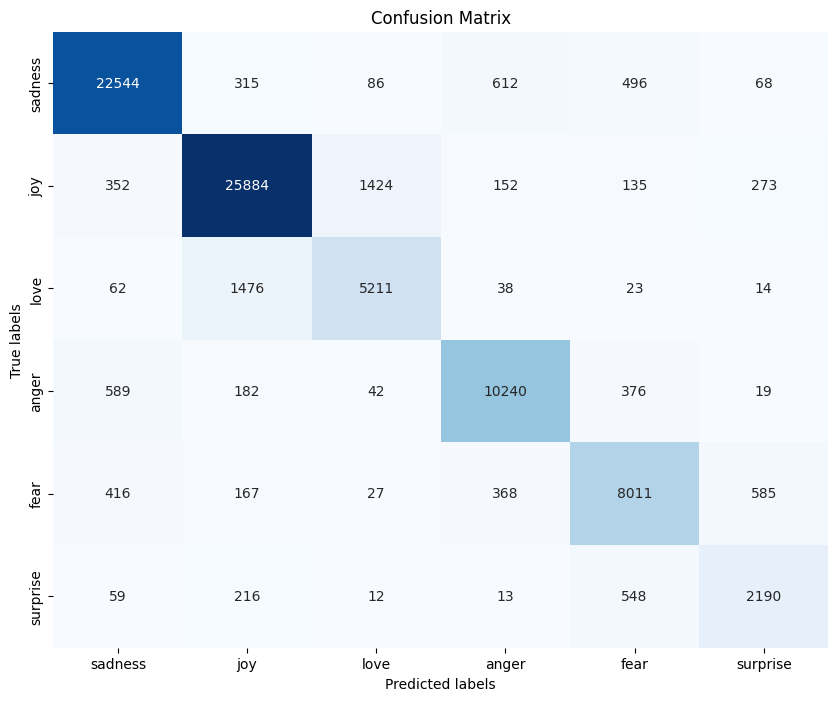

In [21]:
class_labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Data Augmentation techniques

In [5]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    if word in synonyms:
        synonyms.remove(word)
    return list(synonyms)

def synonym_replacement(sentence, n):
    words = sentence.split()
    random_word_list = list(set([word for word in words if word not in stopwords.words('english')]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(synonyms)
            sentence = sentence.replace(random_word, synonym)
            num_replaced += 1
        if num_replaced >= n: # replace up to n words in the sentence
            break

    return sentence

def back_translation(text, src_lang="en", intermediate_lang="fr"):
    tokenizer_src = MarianTokenizer.from_pretrained(f'Helsinki-NLP/opus-mt-{src_lang}-{intermediate_lang}')
    model_src = MarianMTModel.from_pretrained(f'Helsinki-NLP/opus-mt-{src_lang}-{intermediate_lang}')
    tokenizer_inter = MarianTokenizer.from_pretrained(f'Helsinki-NLP/opus-mt-{intermediate_lang}-{src_lang}')
    model_inter = MarianMTModel.from_pretrained(f'Helsinki-NLP/opus-mt-{intermediate_lang}-{src_lang}')

    # Translate to intermediate language
    translated = model_src.generate(**tokenizer_src(text, return_tensors="pt", padding=True))
    inter_text = tokenizer_inter.decode(translated[0], skip_special_tokens=True)

    # Translate back to original language
    back_translated = model_inter.generate(**tokenizer_inter(inter_text, return_tensors="pt", padding=True))
    final_text = tokenizer_src.decode(back_translated[0], skip_special_tokens=True)

    return final_text

# Example usage:
sentence = "I feel happy and joyful."
augmented_sentence = back_translation(sentence)
print("Original:", sentence)
print("Augmented:", augmented_sentence)



[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lukaszchrostowski/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/lukaszchrostowski/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Original: I feel happy and joyful.
Augmented: I feel happy and happy.


In [6]:
# Find the maximum size among the classes
max_size = data['label'].value_counts().max()

# Create a dictionary mapping each class to the number of samples needed
needed_samples = {label: max_size - count for label, count in data['label'].value_counts().items()}
print(needed_samples)


{1: 0, 0: 19790, 3: 83544, 4: 93115, 2: 106282, 5: 125820}


In [11]:
def augment_data(df, label, augmentation_func, samples_needed):
    # Filter the DataFrame to get samples of the specific class
    class_subset = df[df['label'] == label]
    
    # Augment data until the required number of samples is generated
    augmented_texts = []
    while samples_needed > 0:
        # Randomly pick a sample from the subset
        text = class_subset.sample(1)['cleaned_text'].values[0]
        # Generate an augmented version
        augmented_text = augmentation_func(text, n=1) # specify n for synonyms and lng for back_translation
        augmented_texts.append(augmented_text)
        samples_needed -= 1
    
    # Create a new DataFrame with augmented texts and the same label
    new_df = pd.DataFrame({'cleaned_text': augmented_texts, 'label': [label] * len(augmented_texts)})
    return new_df

In [ ]:
data['cleaned_text'] = data['text'].apply(data_cleaning)
data_to_augment = data[['cleaned_text', 'label']]
# Apply augmentation for each class that needs more samples
augmented_dfs = []
for label, count_needed in needed_samples.items():
    if count_needed > 0:
        augmented_df = augment_data(data_to_augment, label, synonym_replacement, count_needed)
        augmented_dfs.append(augmented_df)

# Combine the original DataFrame with the augmented DataFrames
df_augmented = pd.concat([data_to_augment] + augmented_dfs, ignore_index=True)

In [68]:
print(df_augmented)

                                             cleaned_text  label
0                      feel really helpless heavy hearted      4
1       ive enjoyed able slouch relax unwind frankly n...      0
2                 gave internship dmrg feeling distraught      4
3                                     dont know feel lost      0
4       kindergarten teacher thoroughly weary job take...      4
...                                                   ...    ...
844669  feel kings struggle get back playoff come crun...      5
844670  feel inov wear surprised even traction often n...      5
844671           spirit strange sense awe personal growth      5
844672             share feel book peculiar believe think      5
844673  trying feel overwhelmed everything trying make...      5

[844674 rows x 2 columns]


In [69]:
def prepare_data(dataframe, text_column, label_column, test_size=0.2):
    """
    Prepares text data for modeling: splits data, tokenizes, and pads sequences.

    Parameters:
    - dataframe: pandas DataFrame containing the dataset.
    - text_column: string, the name of the column containing the text.
    - label_column: string, the name of the column containing the labels.
    - test_size: float, the proportion of the dataset to include in the test split.

    Returns:
    - X_train, X_test: Tokenized and padded training and testing data.
    - y_train, y_test: Training and testing labels.
    - tokenizer: Fitted tokenizer object.
    - max_length: Maximum length of sequences.
    """
    # Splitting the data into training and testing sets
    X = dataframe[text_column]
    y = dataframe[label_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True)

    # Tokenizing the text
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(dataframe[text_column])

    # Converting text to sequences
    X_train_sequences = tokenizer.texts_to_sequences(X_train)
    X_test_sequences = tokenizer.texts_to_sequences(X_test)

    # Getting the maximum length of data in the sequences for padding
    max_length = max(dataframe[text_column].apply(lambda x: len(str(x).split())))

    # Padding sequences to have the same length
    X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length)
    X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length)

    y_train = pd.get_dummies(y_train, dtype=int)
    y_test = pd.get_dummies(y_test, dtype=int)

    return X_train_padded, X_test_padded, y_train, y_test, tokenizer, max_length

# Example usage:
# Assuming 'df' is your DataFrame with the required columns
X_train, X_test, y_train, y_test, tokenizer, max_length = prepare_data(df_augmented, 'cleaned_text', 'label')


In [84]:
GLOVE_EMB = 'data/glove.6B.300d.txt'

vocab_size = len(tokenizer.word_index) + 1

embeddings_index = {}

f = open(GLOVE_EMB , encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.array(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

EMBEDDING_DIM = 300
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, i in word_index.items():
    if word in embeddings_index:
        embedding_matrix[i] = embeddings_index[word]

Found 400000 word vectors.


In [85]:
embedding_layer = Embedding(
    vocab_size,
    EMBEDDING_DIM,
    embeddings_initializer=Constant(embedding_matrix),
    input_length=max_length,
    trainable=False)

In [72]:
# sequence_input = Input(shape=(X_train.shape[1],))
# embedding_sequences = embedding_layer(sequence_input)

# x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(embedding_sequences)
# outputs = Dense(6, activation='softmax')(x)

# model = Model(sequence_input, outputs)

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

def build_model(input_shape, embedding_layer, lstm_units=64, num_classes=6, dropout_rate=0.2, recurrent_dropout_rate=0.2):
    """
    Build a neural network model for emotion classification using text data.

    Parameters:
    - input_shape: Tuple, shape of the input data.
    - embedding_layer: Pre-trained embedding layer to use for input sequences.
    - lstm_units: Integer, number of units in the LSTM layer.
    - num_classes: Integer, number of emotion classes to predict.
    - dropout_rate: Float, dropout rate for the LSTM layer.
    - recurrent_dropout_rate: Float, recurrent dropout rate for the LSTM layer.

    Returns:
    - Compiled Keras model.
    """
    # Define the input layer
    sequence_input = Input(shape=input_shape)
    
    # Embedding layer from pre-trained embeddings
    embedding_sequences = embedding_layer(sequence_input)
    
    # Bidirectional LSTM layer
    x = Bidirectional(LSTM(lstm_units, dropout=dropout_rate, recurrent_dropout=recurrent_dropout_rate))(embedding_sequences)
    
    # Dense output layer with softmax activation for classification
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # Create and compile the model
    model = Model(inputs=sequence_input, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Print model summary
    model.summary()
    
    return model


## Deep Learning models

In [86]:
# Limited to 5 epochs due to time and resource constraints. You can increase number of epochs.
model = build_model(
    input_shape=(X_train.shape[1],), 
    embedding_layer=embedding_layer,
    lstm_units=64, 
    num_classes=6, 
    dropout_rate=0.2, 
    recurrent_dropout_rate=0.2
)

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 79)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 79, 300)        │    25,075,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 128)            │       186,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,263,454 (96.37 MB)

 Trainable params: 187,654 (733.02 KB)

 Non-trainable params: 25,075,800 (95.66 MB)

In [87]:
history = model.fit(X_train , y_train, validation_split=0.2, epochs=5)
#print(X_train.shape)

Epoch 1/5
16894/16894 ━━━━━━━━━━━━━━━━━━━━ 1057s 62ms/step - accuracy: 0.6804 - loss: 0.8688 - val_accuracy: 0.9092 - val_loss: 0.2575
Epoch 2/5
16894/16894 ━━━━━━━━━━━━━━━━━━━━ 1051s 62ms/step - accuracy: 0.8895 - loss: 0.3142 - val_accuracy: 0.9211 - val_loss: 0.2113
Epoch 3/5
16894/16894 ━━━━━━━━━━━━━━━━━━━━ 1061s 63ms/step - accuracy: 0.9014 - loss: 0.2719 - val_accuracy: 0.9261 - val_loss: 0.1951
Epoch 4/5
16894/16894 ━━━━━━━━━━━━━━━━━━━━ 1062s 63ms/step - accuracy: 0.9061 - loss: 0.2554 - val_accuracy: 0.9291 - val_loss: 0.1834
Epoch 5/5
16894/16894 ━━━━━━━━━━━━━━━━━━━━ 1076s 64ms/step - accuracy: 0.9102 - loss: 0.2450 - val_accuracy: 0.9293 - val_loss: 0.1831


In [88]:
def plot_training_history(history):
    """
    Plot the training and validation loss, as well as the accuracy, from a Keras model training history.

    Parameters:
    - history: A Keras History object returned from the fit method of a model.

    Returns:
    - None; displays matplotlib plots for training/validation loss and accuracy.
    """
    # Extract loss and accuracy from the history object
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Plot training and validation loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(loss, label="Training loss")
    plt.plot(val_loss, label="Validation loss")
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(accuracy, label="Training accuracy")
    plt.plot(val_accuracy, label="Validation accuracy")
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.show()


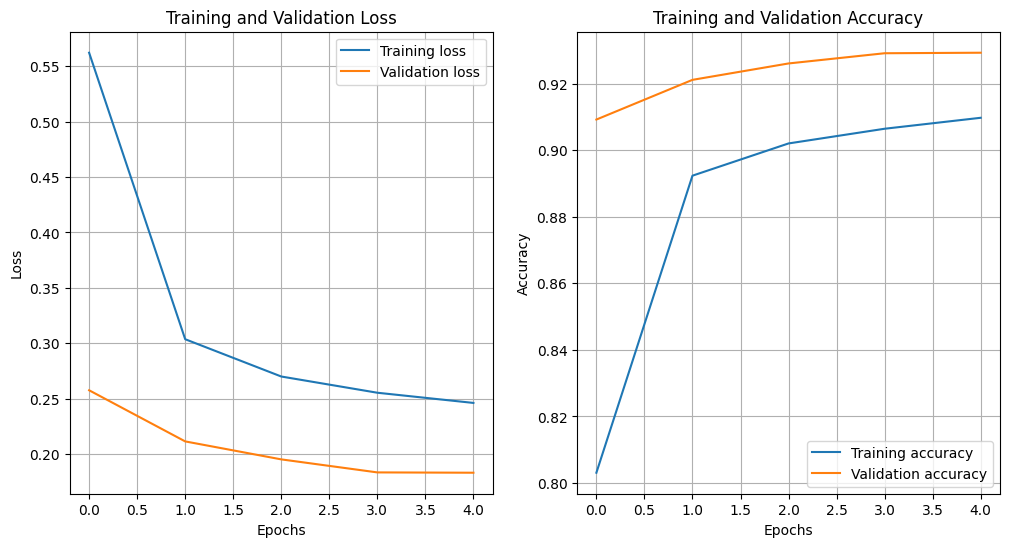

In [89]:
plot_training_history(history)

In [47]:
# predictions = model.predict(X_test)

# y_pred = np.argmax(predictions, axis=1)

# # Convert y_test from one-hot encoded format like [0 0 1 0 0 0] to categorical labels by selecting the index with the highest value
# y_test = np.argmax(y_test, axis=1)

# print(accuracy_score(y_pred, y_test))

def evaluate_model_performance(model, X_test, y_test):
    """
    Evaluate the model's performance on the test dataset and return various classification metrics.

    Parameters:
    - model: Trained Keras model.
    - X_test: Test data features.
    - y_test: True labels for the test data in one-hot encoded format.

    Returns:
    - A dictionary containing accuracy, precision, recall, F1-score, and optionally F2-score.
    """

      # Start the clock to measure prediction time
    start_time = time.time()
    
    # Predict the probabilities for each class
    predictions = model.predict(X_test)
    
    # End the clock after predictions are made
    prediction_time = time.time() - start_time

    # Convert predictions and true labels from one-hot to class integers
    y_pred = np.argmax(predictions, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    # Calculate F2-score using the formula
    # F2 = (1 + beta^2) * (precision * recall) / (beta^2 * precision + recall)
    beta = 2
    f2 = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)

    # Print detailed classification report
    print(classification_report(y_true, y_pred))

    # Return all scores in a dictionary
    scores = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'F2-Score': f2
    }

    return scores

In [90]:
scores = evaluate_model_performance(model, X_test, y_test)
print(scores)

5280/5280 ━━━━━━━━━━━━━━━━━━━━ 112s 21ms/step
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     28150
           1       0.97      0.90      0.93     28272
           2       0.90      0.98      0.94     27913
           3       0.91      0.94      0.93     28385
           4       0.96      0.83      0.89     28274
           5       0.90      0.98      0.94     27941

    accuracy                           0.93    168935
   macro avg       0.93      0.93      0.93    168935
weighted avg       0.93      0.93      0.93    168935

{'Accuracy': 0.9282268328055169, 'Precision': 0.9301115572161859, 'Recall': 0.928439395707159, 'F1-Score': 0.9277515749705382, 'F2-Score': 0.9287733468400414}


In [13]:
def plot_confusion_matrix(model, X_test, y_test, class_labels):
    """
    Plot the confusion matrix for the predictions made by the model on the test dataset.

    Parameters:
    - model: Trained Keras model.
    - X_test: Test data features.
    - y_test: True labels for the test data in one-hot encoded format.
    - class_labels: List of class names corresponding to the labels in y_test.

    Returns:
    - None; displays the confusion matrix using matplotlib and seaborn.
    """
    # Predict the probabilities and convert to class integers
    predictions = model.predict(X_test)
    y_pred = np.argmax(predictions, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot using seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()


5280/5280 ━━━━━━━━━━━━━━━━━━━━ 122s 23ms/step


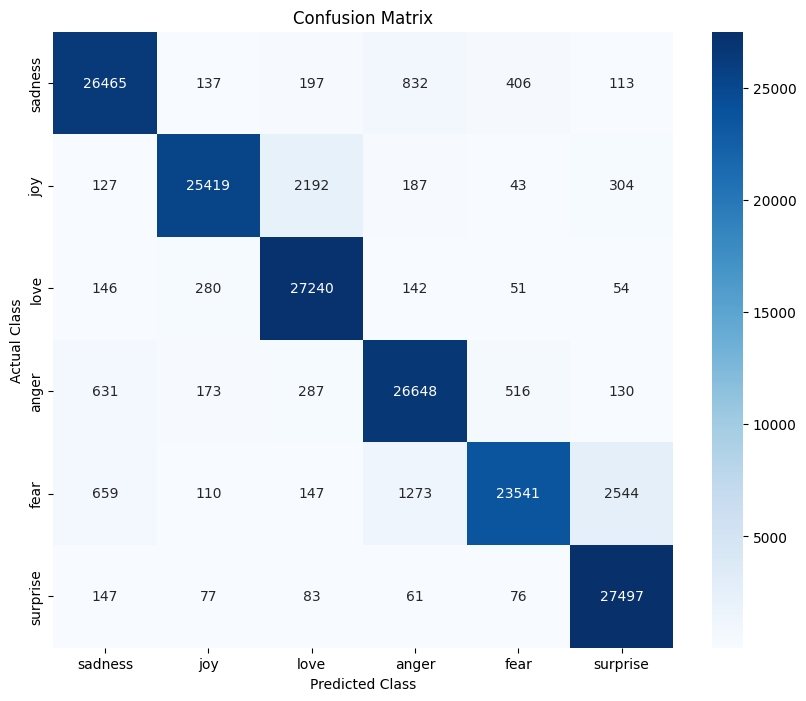

In [91]:
class_labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
plot_confusion_matrix(model, X_test, y_test, class_labels)